In [1]:
# Utility to import jupyter notebook as python module
import io
import os
import sys
import types
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell
from nbformat import current

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    if isinstance(path, str):
        path = [path]
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        else:
            raise IOError('Notebook not found.\n%s' % nb_path)

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("Importing Jupyter notebook: %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')

        # create the module and add it to sys.modules
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.worksheets[0].cells:
            if cell.cell_type == 'code' and cell.language == 'python':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.input)
                # run the code in themodule
                exec(code, mod.__dict__)
        except Exception as e:
            print 'Exception %s raised. Msg: %s' % (e.__class__, e)
        finally:
            self.shell.user_ns = save_user_ns
        return mod



/var/local/polaris/env/celery/local/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [33]:
from IPython.core.pylabtools import figsize
from analysis_engine.library import align
from analysis_engine.node import Parameter
import warnings
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import json
import pandas as pd
import csv
from pprint import pprint
from hdfaccess.file import hdf_file
import pymc as pm
%matplotlib inline

s = { # Thanks to Davidson Pillon source of 'Bayesian Methods for Hackers'
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.facecolor": "#eeeeee",
  "axes.labelsize": "large",
  "axes.grid": 1,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "figure.figsize": (10, 3),
}
import matplotlib
matplotlib.rcParams.update(s)

flight_data_file = '/mnt/analysis/008/409/102/segment_for_pydata.hdf5.gz'

In [26]:
path_model_class = '/var/local/polaris/role/celery/jupyter/notebooks/EndOfTakeOff'
md = NotebookLoader(path=[path_model_class]).load_module('model_classes')
core = NotebookLoader(path=[path_model_class]).load_module('eot_unsupervised_hdf_R')

Importing Jupyter notebook: /var/local/polaris/role/celery/jupyter/notebooks/EndOfTakeOff/model_classes.ipynb
Importing Jupyter notebook: /var/local/polaris/role/celery/jupyter/notebooks/EndOfTakeOff/eot_unsupervised_hdf_R.ipynb
Importing Jupyter notebook: /var/local/polaris/role/celery/jupyter/notebooks/EndOfTakeOff/model_classes.ipynb


In [36]:
def plot_two_params(p1, p2, p1_name='Param 1', p2_name='Param 2', start=0, max_=100):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(np.arange(len(p1[start:max_])), p1[start:max_], color='k')
    ax1.set_ylabel(p1_name)

    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(p2[start:max_])), p2[start:max_], color='r')
    ax2.set_ylabel(p2_name, color='r')
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    plt.grid()
    plt.show()

def plt_ff_EOT(ff, **kwargs):
    ax = plt.subplot(111)
    plt.plot(np.arange(len(ff[460:550])), ff[460:550], 'r-', label='Fuel Flow')
    plt.vlines(76, 500, 4500, linestyle='dashed', lw=1.5, label='EOT')
    plt.vlines(70, 500, 4500, linestyle='dashdot', lw=1.5, color='blue', label='VNAV engaged')
    plt.ylabel('FF')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
    plt.show()

## Aim

Given flight data detect the End of Takeoff (**EOT**) point.

## Approach

- **Probabilistic programming**: rather than detecting a unique point, compute a probability distribution that identifies the most probable points (Bayesian approach).
- **Data driven approach**: build model using data from hundrends of flights and use such a model to predict the EOT for a new flight. 

## Tools: Python

- Numpy, Scipy, Matploltlib, Scikit-Learn;
- PyMC: powerful tool to run Markov Chain Monte Carlo (MCMC) simulations.

# Data

Flight data is given as a `hdf` file.

### Tools

The utilities to open and manage flight data are open source and realised under the *Open Software License* (OSL-3.0).

To open these files we use `FlightDataAccessor`:

    https://github.com/FlightDataServices/FlightDataAccessor


In [1]:
from IPython.core.display import display, HTML
display(HTML(
    '<iframe src="http://flightdataaccessor.readthedocs.io/en/latest/" width=800 height=400></iframe>'
))

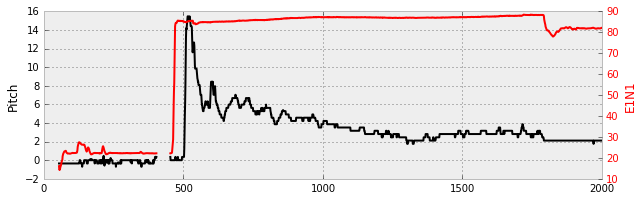

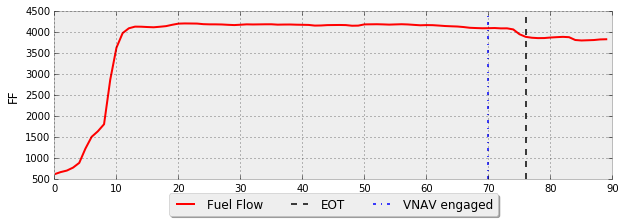

In [41]:
from hdfaccess.file import hdf_file
from analysis_engine.library import align
from analysis_engine.node import Parameter

with hdf_file(flight_data_file, read_only=True) as hdf:
        pitch = hdf['Pitch']
        e1n1 = hdf['Eng (1) N1']
        ff = hdf['Eng (1) Fuel Flow']

p = Parameter('dummy', frequency=1)
pitch, e1n1, ff = align(pitch, p), align(e1n1, p), align(ff, p)

plot_two_params(pitch, e1n1, p1_name='Pitch', p2_name='E1N1', max_=2000)
plt_ff_EOT(ff, VNAV=True, EOT=True)

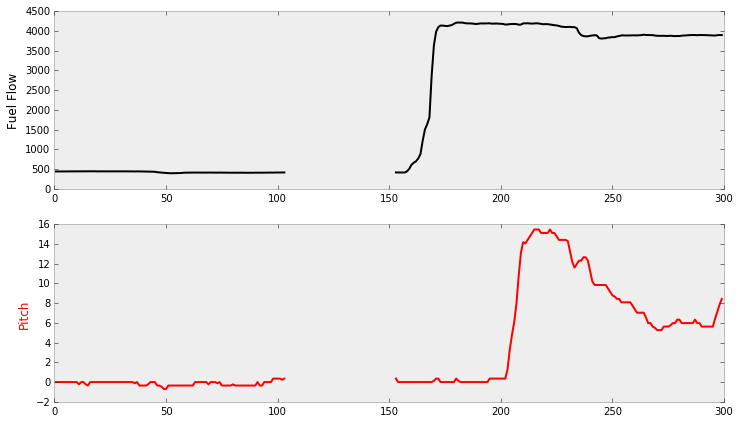

In [31]:
# Some more graphs, not in the slides..
figsize(12, 7)
plt.subplot(211)
plt.plot(np.arange(len(ff[300:600])), ff[300:600], color='k')
plt.ylabel('Fuel Flow')
plt.grid()
plt.subplot(212)
plt.plot(np.arange(len(pitch[300:600])), pitch[300:600], color='r')
plt.ylabel('Pitch', color='r')
plt.grid()
plt.show()

# Strategy

#### 1. Fit the model
 - Collect flight data with **VNAV** parameter;
 - Find **EOT** around **VNAV=engaged**;
 - Collect samples of relevant parameters.

#### 2. Prediction
  - Given any flight, use the samples to compute probability that a point is the **EOT**.

#### Why?
Because **VNAV** is not present all the time.

# I. Model

For this talk we choose only two parameters:
- **Fuel Flow** (FF), and
- **Exhaust Gas Temperature** (EGT).

These parameters are time series **piecewise constant** (during the climb phase).

The data is centered around **VNAV=engaged**:
$$
D=\Bigl(ff(t), egt(t)\Bigr),\ t=1,...,20.
$$

- **Aim**: Find probability distribution of time (say $\tau$) when the two parameters change.
- **Tool**: PyMC.

**Notation**: Say $\hat{\theta}=(\tau,\,ff_1,\,ff_2,\, egt_1,\, egt_2)$.

**Strategy**: Apply Bayes theorem to compute

$$
p\bigl(\hat{\theta}\mid D\bigr) = \frac{p\bigl(D\mid\hat{\theta}\bigr)\: p\bigl(\hat{\theta}\bigr)}{p(D)}.
$$

Where

$$
\begin{align}
(D\mid ff_1,\, ff_2,\, \tau) &\sim \mathcal{N}(\mu_d,\sigma_d),\hspace{0.2cm}\\
&\hspace{1cm}\mu_d=\left\{
                \begin{array}{ll}
                  ff_1,\: t\leq\tau\\
                  ff_2,\: t\geq\tau
                \end{array}
              \right.,\hspace{0.1cm}\sigma_d\sim\mathcal{Unif}(1,50),\\
\tau&\sim\mathcal{DUnif}(1, 20),\\
ff_1,\: ff_2&\sim\mathcal{N}(\mu_{ff}, \sigma_{ff}),\hspace{0.2cm}\left\{
                \begin{array}{ll}
                  \mu_{ff}=\mbox{mean}(ff)\\
                  \sigma_{ff}\propto\mbox{magnitude}(ff)
                \end{array}
              \right..\\
\end{align}
$$

In [7]:
import pymc as pm
class SwitchPointFinder2Dim(object):
    def __init__(self, data1, data2, lower_prec):
        var1, var2 = 10 ** int(np.log10(data1.mean())) / 2, 10 ** int(np.log10(data2.mean())) / 2
        # Priors
        self.idx = pm.DiscreteUniform('idx', lower=1, upper=len(data1))

        self.ff_1 = pm.Normal('ff_mean_1', mu=data1.mean(), tau=1.0/var1)
        self.ff_2 = pm.Normal('ff_mean_2', mu=data1.mean(), tau=1.0/var1)

        self.egt_1 = pm.Normal('egt_mean_1', mu=data2.mean(), tau=1.0/var2)
        self.egt_2 = pm.Normal('egt_mean_2', mu=data2.mean(), tau=1.0/var2)
        # precision of likelihood
        self.tau = pm.Uniform('tau', lower=1.0/lower_prec, upper=1.0/1, size=2)

        @pm.deterministic
        def mean_1(
            idx=self.idx, ff_1=self.ff_1, ff_2=self.ff_2):
            out_ff = np.zeros(len(data1))
            out_ff[:idx], out_ff[idx:] = ff_1, ff_2
            return out_ff
        @pm.deterministic
        def mean_2(
            idx=self.idx, egt_1=self.egt_1, egt_2=self.egt_2):
            out_egt = np.zeros(len(data1))
            out_egt[:idx], out_egt[idx:] = egt_1, egt_2
            return out_egt
        @pm.deterministic
        def mean(m1=mean_1, m2=mean_2):
            return np.array([m1, m2]).T

        # Likelyhood as sum of log-likelyhood
        @pm.observed
        def observation(
            value=np.array([data1, data2], dtype=object).T,
            mean=mean, prec=self.tau
        ):
            return sum(
                pm.normal_like(v[0], m[0], prec[0]) + pm.normal_like(v[1], m[1], prec[1])
                for v, m in zip(value, mean)
            )

def example_run_mcmc(data_ff, data_egt):
    data_model = SwitchPointFinder2Dim(data_ff, data_egt, 500)
    model = pm.Model(data_model)

    mcmc = pm.MCMC(model)
    mcmc.sample(10000, 8000, 2)

Use FF-EGT as training parameter
 [-----------------100%-----------------] 10000 of 10000 complete in 17.1 sec
********************
Idx absolute:  Counter({29.0: 2000})
Idx relative:  Counter({16: 2000})
********************


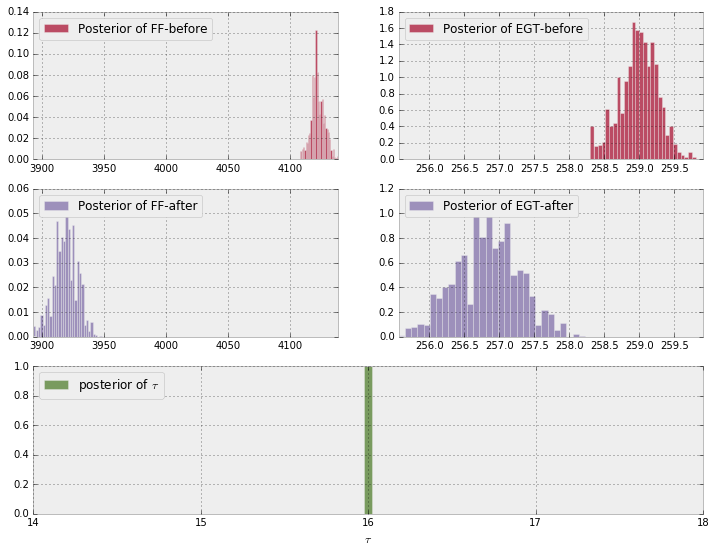

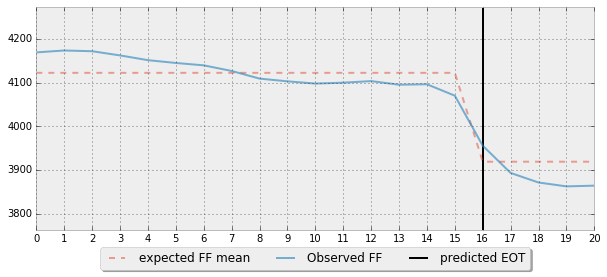

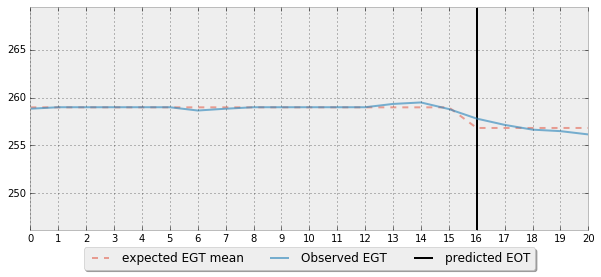

In [10]:
_ = core.run_and_plot(
    core.segments_file, dump_json=False,
    param1='ff', param2='egt', dim=2,
)

No second parameter - One dimensional model to run..
Use FF as training parameter
 [-----------------100%-----------------] 10000 of 10000 complete in 2.9 sec
********************
Idx absolute:  Counter({29.0: 2000})
Idx relative:  Counter({16: 2000})
********************


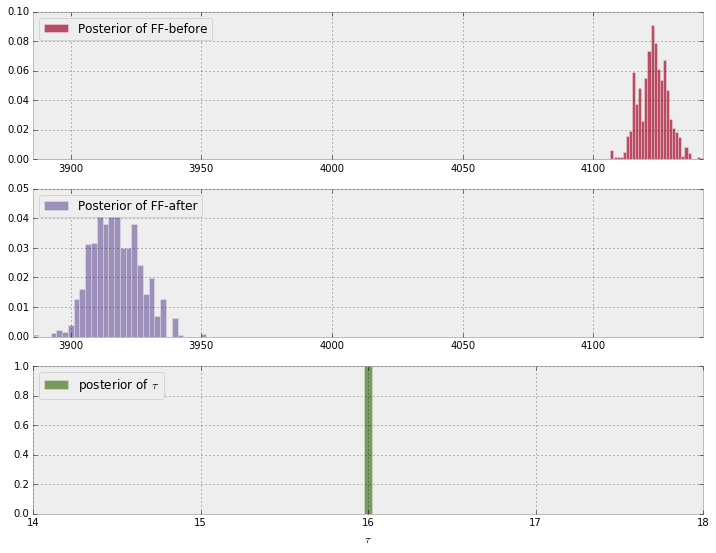

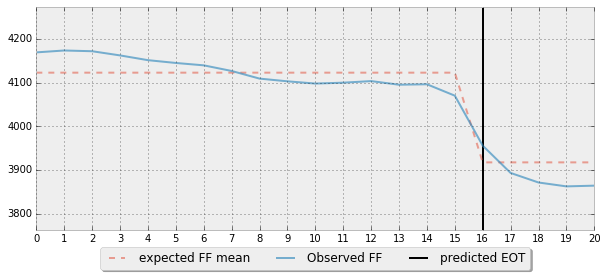

In [11]:
_ = core.run_and_plot(
    core.segments_file, dump_json=False,
    param1='ff', param2=None, dim=1,
)

Use FF-ALT as training parameter
 [-----------------100%-----------------] 10000 of 10000 complete in 17.8 sec
********************
Idx absolute:  Counter({23.0: 1963, 24.0: 37})
Idx relative:  Counter({10: 1963, 11: 37})
********************


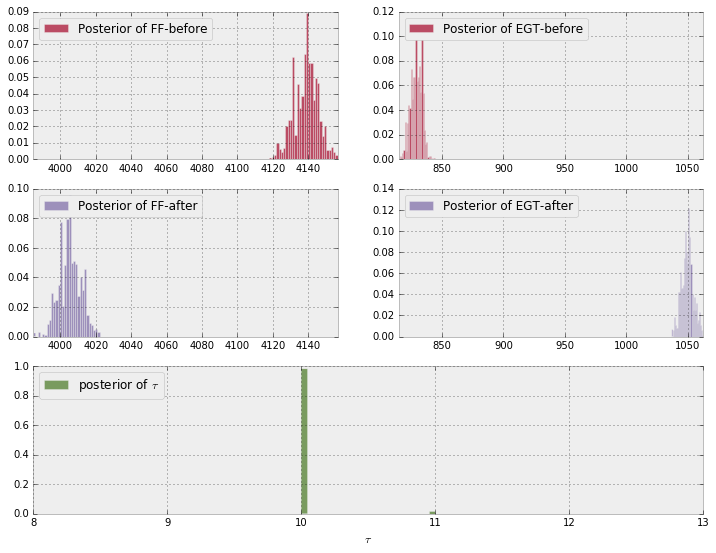

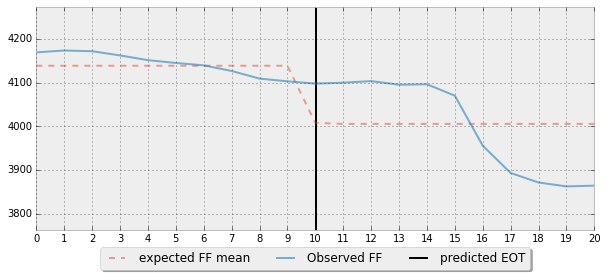

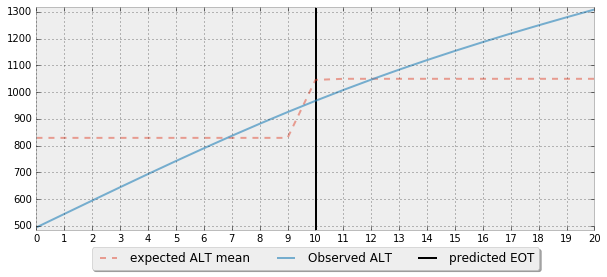

In [12]:
# Example using Fuel Flow and Altitude -> ALT cannot be a training parameter!
_ = core.run_and_plot(
    core.segments_file, dump_json=False,
    param1='ff', param2='alt', dim=2,
)

# II. Prediction

- Run previous model on a number of flights (more than 200, of same fleet!);

- Collect samples in one single file:
![picture](img/samples_300_ff_egt.png)

- Use samples as likelihood of the prediction Bayesian formula:
$$
p(\hat{\theta} \mid EOT)\propto\prod_i p(EOT\mid \theta_i)\:p(\theta_i),
$$
where $\theta=(t,\: ff,\: egt)$.

# Example

#### Priors:

$$
\begin{align}
t&\sim\mathcal{DUnif}(15, 300)\\
ff_1,\: ff_2&\sim\mathcal{N}(\mu=3600, \sigma=300)\\
egt_1,\: egt_2&\sim\mathcal{N}(\mu=250, \sigma=100)\\
\end{align}
$$

#### Likelihood:
```from scipy import stats
likelihood_time = stats.gaussian_kde(
    likelihoods['time'],
    bw_method=0.4
)```

Real EOT:	41 seconds after takeoff
Predicted EOT:	42 seconds after takeoff


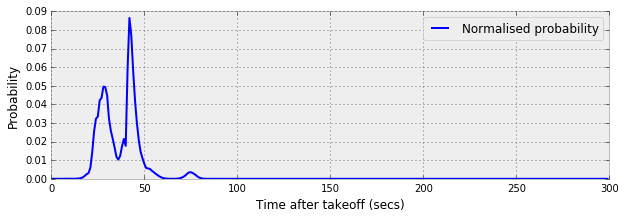

In [12]:
_ = core.predict_eot(core.filename_25_41, s=core.samples_likelihoods, MAX_TIME=300)

Predicted EOT:	31 seconds after takeoff


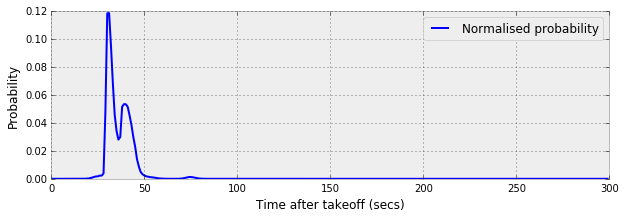

In [12]:
# Another example skipped in the slides - here Real EOT=29 secs
_ = core.predict_eot(core.filename_11_29, s=core.samples_likelihoods, MAX_TIME=300)

<img src="img/questions_no_answers.jpg" width="70%" height="70%" />

<img src="img/FDS-logo-new-lg-transp.jpg" align=center width="100" height="100"/>
### We're hiring a Software Developer! (Python, Django, Big Data..)


PyMC reference:
 - PyMC docs: `https://pymc-devs.github.io/pymc/index.html`
 - Cameron Davidson-Pilon, *"Bayesian Methods for Hackers"* (on `http://nbviewer.jupyter.org/`)